### **Baseline MobileNet**
* **Model**
  * from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/mobilenet.py
  * ML_Week12_ResNet 코드 참고 및 일부 수정하여 기본 베이스라인 모델 성능 측정
* **Best accuracy** : [Test set] Average loss: 0.0056, Accuracy: 8426/10000 (84.26%)
* **FLOPS** : 48,412,672

* **hyperparameter**
  * lr=0.03
  * weight_decay=5e-4
  * batch size = 100
  * epoch = 100
  * training time : 3484.9894 sec

* **optimizer**
  * SGD

* **Data augmentation**
  *   
          transforms.Pad(4),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(32),
          transforms.ToTensor()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/ML Project/Baseline/model"

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Current GPU Index: 0
Current GPU Name: Tesla T4


In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True,
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False,
                                transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 71092429.72it/s]


Extracting ./cifar_10data/cifar-10-python.tar.gz to ./cifar_10data/


In [ ]:
'''MobileNet in PyTorch.

from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/mobilenet.py

See the paper "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications"
for more details.
'''

class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = MobileNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

# test()

In [ ]:
from torchsummary import summary

model = MobileNet().to(device)

print("MobileNet torchsummary")
summary(model, (3, 32, 32))

MobileNet torchsummary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]             288
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]           2,048
       BatchNorm2d-6           [-1, 64, 32, 32]             128
             Block-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]             576
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 128, 16, 16]           8,192
      BatchNorm2d-11          [-1, 128, 16, 16]             256
            Block-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           1,152
      BatchNorm2

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=ae63ffbd3f05fced6350199afdbef21a81ce5c14ecd5e80134dfff656dc2f47f
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=45393ed8bb476f206864c6405e867e40abc4a3db7a7be67c09ffe74680ba1e08
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis

inputs = torch.randn(1, 3, 32, 32).to(device)

flops = FlopCountAnalysis(model, inputs)
print(flops.total())  # 총 FLOPS 출력

48412672


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=5e-4)

In [ ]:
from tqdm import tqdm
import torch
import os

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

best_accuracy = 0.0
accuracy_list = []
test_loss_list = []
train_loss_list = []

import time
start = time.time()


for epoch in range(100):
    print(f"{epoch}th epoch starting.")
    batch_num = len(train_loader)

    train_loss_epoch, test_loss, correct, total = 0, 0, 0, 0


    pbar = tqdm(enumerate(train_loader), total=batch_num, dynamic_ncols=True, position=0, leave=True)
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()
        train_loss_epoch += train_loss.item()

        # 현재 배치의 Loss 값 표시
        pbar.set_description(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {train_loss.item():.4f}")

    train_loss_list.append(train_loss_epoch / batch_num)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            # total += labels.size(0)

    accuracy = 100. * correct / total
    # test_loss_list.append(test_loss / total)
    test_loss_list.append(test_loss / batch_num)
    accuracy_list.append(accuracy)

    # 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_filename = f"best_model_epoch_{epoch+1}.pkt"
        model_save_path = os.path.join(save_path, model_filename)

        torch.save(model.state_dict(), model_save_path)
        # print(f"Epoch {epoch + 1}: Best model saved with accuracy: {accuracy:.4f}")

end = time.time()
print("Time elapsed in training is: {}".format(end - start))

0th epoch starting.


Epoch 1, Batch 500, Loss: 1.8365: 100%|██████████| 500/500 [00:36<00:00, 13.74it/s]


1th epoch starting.


Epoch 2, Batch 500, Loss: 1.4914: 100%|██████████| 500/500 [00:33<00:00, 15.04it/s]


2th epoch starting.


Epoch 3, Batch 500, Loss: 1.3453: 100%|██████████| 500/500 [00:33<00:00, 14.94it/s]


3th epoch starting.


Epoch 4, Batch 500, Loss: 1.3192: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


4th epoch starting.


Epoch 5, Batch 500, Loss: 1.2510: 100%|██████████| 500/500 [00:34<00:00, 14.62it/s]


5th epoch starting.


Epoch 6, Batch 500, Loss: 1.1506: 100%|██████████| 500/500 [00:32<00:00, 15.21it/s]


6th epoch starting.


Epoch 7, Batch 500, Loss: 1.0460: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


7th epoch starting.


Epoch 8, Batch 500, Loss: 1.0093: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


8th epoch starting.


Epoch 9, Batch 500, Loss: 0.8766: 100%|██████████| 500/500 [00:32<00:00, 15.23it/s]


9th epoch starting.


Epoch 10, Batch 500, Loss: 1.2148: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


10th epoch starting.


Epoch 11, Batch 500, Loss: 0.6998: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


11th epoch starting.


Epoch 12, Batch 500, Loss: 0.7555: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


12th epoch starting.


Epoch 13, Batch 500, Loss: 0.8812: 100%|██████████| 500/500 [00:32<00:00, 15.25it/s]


13th epoch starting.


Epoch 14, Batch 500, Loss: 0.7538: 100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


14th epoch starting.


Epoch 15, Batch 500, Loss: 0.7929: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


15th epoch starting.


Epoch 16, Batch 500, Loss: 0.5969: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


16th epoch starting.


Epoch 17, Batch 500, Loss: 0.6699: 100%|██████████| 500/500 [00:32<00:00, 15.48it/s]


17th epoch starting.


Epoch 18, Batch 500, Loss: 0.5915: 100%|██████████| 500/500 [00:32<00:00, 15.34it/s]


18th epoch starting.


Epoch 19, Batch 500, Loss: 0.5256: 100%|██████████| 500/500 [00:32<00:00, 15.30it/s]


19th epoch starting.


Epoch 20, Batch 500, Loss: 0.5734: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


20th epoch starting.


Epoch 21, Batch 500, Loss: 0.6614: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


21th epoch starting.


Epoch 22, Batch 500, Loss: 0.5309: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


22th epoch starting.


Epoch 23, Batch 500, Loss: 0.4904: 100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


23th epoch starting.


Epoch 24, Batch 500, Loss: 0.5366: 100%|██████████| 500/500 [00:32<00:00, 15.32it/s]


24th epoch starting.


Epoch 25, Batch 500, Loss: 0.6037: 100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


25th epoch starting.


Epoch 26, Batch 500, Loss: 0.4773: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


26th epoch starting.


Epoch 27, Batch 500, Loss: 0.6072: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


27th epoch starting.


Epoch 28, Batch 500, Loss: 0.5124: 100%|██████████| 500/500 [00:32<00:00, 15.22it/s]


28th epoch starting.


Epoch 29, Batch 500, Loss: 0.5088: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


29th epoch starting.


Epoch 30, Batch 500, Loss: 0.3075: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


30th epoch starting.


Epoch 31, Batch 500, Loss: 0.4562: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


31th epoch starting.


Epoch 32, Batch 500, Loss: 0.3230: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


32th epoch starting.


Epoch 33, Batch 500, Loss: 0.4031: 100%|██████████| 500/500 [00:32<00:00, 15.50it/s]


33th epoch starting.


Epoch 34, Batch 500, Loss: 0.3614: 100%|██████████| 500/500 [00:32<00:00, 15.24it/s]


34th epoch starting.


Epoch 35, Batch 500, Loss: 0.4214: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


35th epoch starting.


Epoch 36, Batch 500, Loss: 0.2908: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


36th epoch starting.


Epoch 37, Batch 500, Loss: 0.3119: 100%|██████████| 500/500 [00:32<00:00, 15.49it/s]


37th epoch starting.


Epoch 38, Batch 500, Loss: 0.2821: 100%|██████████| 500/500 [00:32<00:00, 15.47it/s]


38th epoch starting.


Epoch 39, Batch 500, Loss: 0.3778: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


39th epoch starting.


Epoch 40, Batch 500, Loss: 0.4427: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


40th epoch starting.


Epoch 41, Batch 500, Loss: 0.2373: 100%|██████████| 500/500 [00:32<00:00, 15.52it/s]


41th epoch starting.


Epoch 42, Batch 500, Loss: 0.3101: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


42th epoch starting.


Epoch 43, Batch 500, Loss: 0.2892: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


43th epoch starting.


Epoch 44, Batch 500, Loss: 0.2240: 100%|██████████| 500/500 [00:32<00:00, 15.35it/s]


44th epoch starting.


Epoch 45, Batch 500, Loss: 0.2421: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


45th epoch starting.


Epoch 46, Batch 500, Loss: 0.3697: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


46th epoch starting.


Epoch 47, Batch 500, Loss: 0.2709: 100%|██████████| 500/500 [00:32<00:00, 15.46it/s]


47th epoch starting.


Epoch 48, Batch 500, Loss: 0.1884: 100%|██████████| 500/500 [00:32<00:00, 15.49it/s]


48th epoch starting.


Epoch 49, Batch 500, Loss: 0.2128: 100%|██████████| 500/500 [00:32<00:00, 15.49it/s]


49th epoch starting.


Epoch 50, Batch 500, Loss: 0.2960: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


50th epoch starting.


Epoch 51, Batch 500, Loss: 0.2941: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


51th epoch starting.


Epoch 52, Batch 500, Loss: 0.3900: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


52th epoch starting.


Epoch 53, Batch 500, Loss: 0.3030: 100%|██████████| 500/500 [00:32<00:00, 15.43it/s]


53th epoch starting.


Epoch 54, Batch 500, Loss: 0.2544: 100%|██████████| 500/500 [00:32<00:00, 15.43it/s]


54th epoch starting.


Epoch 55, Batch 500, Loss: 0.2783: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


55th epoch starting.


Epoch 56, Batch 500, Loss: 0.3315: 100%|██████████| 500/500 [00:32<00:00, 15.35it/s]


56th epoch starting.


Epoch 57, Batch 500, Loss: 0.2973: 100%|██████████| 500/500 [00:32<00:00, 15.44it/s]


57th epoch starting.


Epoch 58, Batch 500, Loss: 0.2641: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


58th epoch starting.


Epoch 59, Batch 500, Loss: 0.2378: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


59th epoch starting.


Epoch 60, Batch 500, Loss: 0.2521: 100%|██████████| 500/500 [00:32<00:00, 15.34it/s]


60th epoch starting.


Epoch 61, Batch 500, Loss: 0.2055: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


61th epoch starting.


Epoch 62, Batch 500, Loss: 0.2252: 100%|██████████| 500/500 [00:32<00:00, 15.34it/s]


62th epoch starting.


Epoch 63, Batch 500, Loss: 0.1740: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


63th epoch starting.


Epoch 64, Batch 500, Loss: 0.3262: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


64th epoch starting.


Epoch 65, Batch 500, Loss: 0.1915: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


65th epoch starting.


Epoch 66, Batch 500, Loss: 0.2696: 100%|██████████| 500/500 [00:32<00:00, 15.26it/s]


66th epoch starting.


Epoch 67, Batch 500, Loss: 0.1520: 100%|██████████| 500/500 [00:32<00:00, 15.43it/s]


67th epoch starting.


Epoch 68, Batch 500, Loss: 0.1602: 100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


68th epoch starting.


Epoch 69, Batch 500, Loss: 0.2271: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


69th epoch starting.


Epoch 70, Batch 500, Loss: 0.1878: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


70th epoch starting.


Epoch 71, Batch 500, Loss: 0.1353: 100%|██████████| 500/500 [00:32<00:00, 15.22it/s]


71th epoch starting.


Epoch 72, Batch 500, Loss: 0.2070: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


72th epoch starting.


Epoch 73, Batch 500, Loss: 0.1843: 100%|██████████| 500/500 [00:32<00:00, 15.35it/s]


73th epoch starting.


Epoch 74, Batch 500, Loss: 0.1770: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


74th epoch starting.


Epoch 75, Batch 500, Loss: 0.1501: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


75th epoch starting.


Epoch 76, Batch 500, Loss: 0.0957: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


76th epoch starting.


Epoch 77, Batch 500, Loss: 0.2234: 100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


77th epoch starting.


Epoch 78, Batch 500, Loss: 0.1782: 100%|██████████| 500/500 [00:32<00:00, 15.43it/s]


78th epoch starting.


Epoch 79, Batch 500, Loss: 0.1843: 100%|██████████| 500/500 [00:32<00:00, 15.35it/s]


79th epoch starting.


Epoch 80, Batch 500, Loss: 0.1566: 100%|██████████| 500/500 [00:32<00:00, 15.34it/s]


80th epoch starting.


Epoch 81, Batch 500, Loss: 0.2358: 100%|██████████| 500/500 [00:32<00:00, 15.33it/s]


81th epoch starting.


Epoch 82, Batch 500, Loss: 0.2570: 100%|██████████| 500/500 [00:32<00:00, 15.22it/s]


82th epoch starting.


Epoch 83, Batch 500, Loss: 0.1833: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


83th epoch starting.


Epoch 84, Batch 500, Loss: 0.3140: 100%|██████████| 500/500 [00:32<00:00, 15.27it/s]


84th epoch starting.


Epoch 85, Batch 500, Loss: 0.2273: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


85th epoch starting.


Epoch 86, Batch 500, Loss: 0.1471: 100%|██████████| 500/500 [00:32<00:00, 15.27it/s]


86th epoch starting.


Epoch 87, Batch 500, Loss: 0.0820: 100%|██████████| 500/500 [00:32<00:00, 15.17it/s]


87th epoch starting.


Epoch 88, Batch 500, Loss: 0.1939: 100%|██████████| 500/500 [00:32<00:00, 15.35it/s]


88th epoch starting.


Epoch 89, Batch 500, Loss: 0.1479: 100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


89th epoch starting.


Epoch 90, Batch 500, Loss: 0.0625: 100%|██████████| 500/500 [00:32<00:00, 15.48it/s]


90th epoch starting.


Epoch 91, Batch 500, Loss: 0.0387: 100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


91th epoch starting.


Epoch 92, Batch 500, Loss: 0.2613: 100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


92th epoch starting.


Epoch 93, Batch 500, Loss: 0.1299: 100%|██████████| 500/500 [00:32<00:00, 15.34it/s]


93th epoch starting.


Epoch 94, Batch 500, Loss: 0.1635: 100%|██████████| 500/500 [00:32<00:00, 15.43it/s]


94th epoch starting.


Epoch 95, Batch 500, Loss: 0.0881: 100%|██████████| 500/500 [00:32<00:00, 15.46it/s]


95th epoch starting.


Epoch 96, Batch 500, Loss: 0.1754: 100%|██████████| 500/500 [00:32<00:00, 15.42it/s]


96th epoch starting.


Epoch 97, Batch 500, Loss: 0.1337: 100%|██████████| 500/500 [00:32<00:00, 15.47it/s]


97th epoch starting.


Epoch 98, Batch 500, Loss: 0.1036: 100%|██████████| 500/500 [00:32<00:00, 15.36it/s]


98th epoch starting.


Epoch 99, Batch 500, Loss: 0.1190: 100%|██████████| 500/500 [00:32<00:00, 15.45it/s]


99th epoch starting.


Epoch 100, Batch 500, Loss: 0.1284: 100%|██████████| 500/500 [00:32<00:00, 15.32it/s]


Time elapsed in training is: 3484.9894104003906


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Test Loss': test_loss_list,
    'Train Loss' : train_loss_list
})

df.to_csv('/content/drive/MyDrive/ML Project/Baseline/metrics.csv', index=False)

In [ ]:
df.tail()

,Accuracy,Test Loss,Train Loss
95,83.20,0.006082,0.132644
96,83.31,0.006107,0.130926
97,83.45,0.006025,0.127933
98,82.71,0.006301,0.126466
99,82.86,0.006491,0.121240


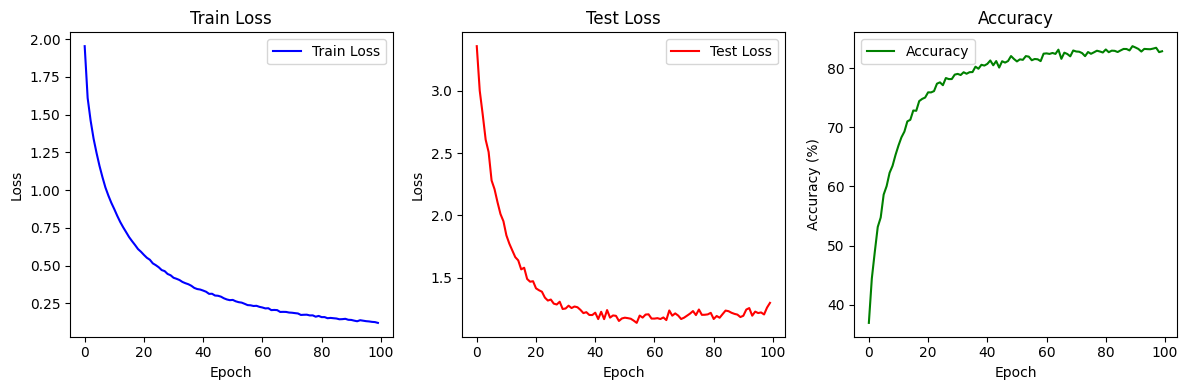

In [ ]:
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/ML Project/Baseline/metrics.csv')

# 그래프 크기 설정
plt.figure(figsize=(12, 4))

# Train Loss
plt.subplot(1, 3, 1)
plt.plot(df['Train Loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# Test Loss
plt.subplot(1, 3, 2)
plt.plot(df['Test Loss'] * 200, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(df['Accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = MobileNet().to(device)

# 저장된 Best 가중치 불러오기
model_path = '/content/drive/MyDrive/ML Project/Baseline/model/best_model_epoch_90.pkt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0056, Accuracy: 8426/10000 (84.26%)



In [ ]:
# Best 가중치 상위 폴더 저장
import shutil

source_path = '/content/drive/MyDrive/ML Project/Baseline/model/best_model_epoch_90.pkt'
destination_path = '/content/drive/MyDrive/ML Project/Baseline/'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ML Project/Baseline/best_model_epoch_90.pkt'